# Predict Mod7 phase set point from 400 MeV BPM data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import sklearn.mixture
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

%matplotlib widget
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["savefig.format"] = 'pdf'
plt.rc("axes",prop_cycle= plt.cycler("color", plt.cm.tab20.colors))

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import LearningRateScheduler

print(tf.__version__)

Init Plugin
2.5.0
Init Graph Optimizer
Init Kernel


## DNN regression models

The base model contains the following layers:

* The normalization layer.
* N hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

We also test a model without input normalization layer.

In [3]:
def build_and_compile_model(norm, init_lr):
  model = keras.Sequential([
      norm,
      layers.Dense(20, activation='relu'),#500
      #layers.BatchNormalization(),
      layers.Dense(20, activation='relu'),
      #layers.BatchNormalization(),
      layers.Dense(20, activation='relu'),
      #layers.BatchNormalization(),
      #layers.Dense(50, activation='relu'),
      #layers.BatchNormalization(),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

def build_and_compile_model_nonorm(inputs,init_lr):
  model = keras.Sequential([
      keras.Input(shape=(inputs,)),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      #layers.Dense(100, activation='relu'),
      #layers.Dense(100, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

## Define learning schedules and training

In [4]:
# Define learning schedules 

initial_lr = 0.001

def lr_time_based_decay(epoch, lr):
    epochs = 400
    decay = initial_lr / epochs
    return lr * 1 / (1 + decay * epoch)


def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 200.0
    return initial_lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_lr * math.exp(-k*epoch)



In [5]:
def train_model(model,features,labels,eps,lrs=None):
    if lrs is None:
        history = model.fit(
            features, 
            labels,
            validation_split=0.2,
            batch_size=30, #64
            verbose=0,
            epochs=int(eps)
        )
    else:
        history = model.fit(
            features, 
            labels, 
            validation_split=0.2,
            batch_size=30,
            verbose=0,
            epochs=int(eps), 
            callbacks=[LearningRateScheduler(lrs, verbose=0)],
        )
    return history

## Define plotting functions

In [6]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 4])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

def plot_multi_loss(histories):
    fig, ax = plt.subplots(len(histories),1,figsize=(9,9))
    for i in range(len(histories)):
        ax[i].plot(histories[i].history['loss'], label='loss')
        ax[i].plot(histories[i].history['val_loss'], label='val_loss')
        ax[i].set_ylim([0, 4])
        ax[i].set(xlabel='Epoch', ylabel='Loss')
        ax[i].legend()
        ax[i].grid(True)
        
    fig.tight_layout()


In [7]:
def plot_2dhist(predictions,labels):

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    fig.tight_layout()
    devs = ['SC Linac Module 7']
    
    for i in range(labels.shape[1]):
        #key = labels.columns[i]
        key = devs[i]
        h = ax.hist2d(labels.iloc[:,i], predictions[:,i], bins=40, cmin=1, cmap='winter')
        #ax.set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        ax.set(title='%s'%key)
        ax.tick_params(axis='both',labelsize=14)
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.plot(lims, lims, color='k')
        fig.colorbar(h[3], ax=ax)
    fig.supylabel('Predicted $\Delta$ phase (deg)', fontsize=18)
    fig.suptitle('True $\Delta$ phase (deg)', y=0.05, fontsize=18)   
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.subplots_adjust(bottom=0.15)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.14)
    plt.subplots_adjust(right=0.96)  

In [8]:
def plot_2dscatter(predictions,labels):

    fig, ax = plt.subplots(1,1, figsize=(4,4))

    for i in range(labels.shape[1]):
        key = labels.columns[i]
        ax.scatter(labels.iloc[:,i], predictions[:,i], color='r')
        ax.set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        print(lims)
        ax.plot(lims, lims, color='b')    
    fig.tight_layout()

In [9]:
def plot_1derror(predictions,labels):
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)
    devs = ['phase set point']
    fig, ax = plt.subplots(1,1, figsize=(5,5),sharey=False)
    fig.tight_layout()
    for i in range(labels.shape[1]):
        #key = labels.columns[i]
        key = devs[i]
        #error =(predictions[:,i] - labels.iloc[:,i])
        error =(predictions[:,i] - labels.iloc[:,i])
        nbins=85
        ax.hist(error, bins=nbins, color='r', edgecolor='k', alpha=0.65, label='Data')
        #ax.set(title='%s'%key ,xlabel='Prediction Error (deg)', ylabel='Count')
        ax.set(title='%s'%key)
        #ax.xaxis.label.set_size(13)
        #ax.yaxis.label.set_size(13)
        
        ers = np.array(error)[:,None]
        gmm = sklearn.mixture.GaussianMixture()  
        r = gmm.fit(ers)
        mean = r.means_[0, 0]
        sigma = np.sqrt(r.covariances_[0,0])
        textstr = '\n'.join((
                    r'$\mu=%.2f$' % (mean,),
                    r'$\sigma=%.2f$' % (sigma,)))
        print(textstr)                                                                                                                  
        xlin = np.linspace(np.min(error),np.max(error),1000).reshape(-1,1)                                                                                                                             
        pdf = np.exp(gmm.score_samples(xlin))
        binsize = (np.max(error) - np.min(error))/nbins
        ax.plot(xlin,pdf*(len(error)*binsize),color='k', label='Gauss fit')
        ax.text(0.05, 0.65, textstr, transform=ax.transAxes, color='k', fontsize=14,                                                                                
                           verticalalignment='top', bbox=props)
        ax.legend(fontsize=14, loc='upper left')
        ax.tick_params(axis='both',labelsize=14)
     
    fig.supylabel('Entries/Bin', fontsize=18)
    fig.suptitle('Prediction error (degrees)', y=0.05, fontsize=18)
    plt.subplots_adjust(wspace=0.19, hspace=0)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.09)
    plt.subplots_adjust(right=0.96)  


## Define data loading functions

In [10]:
def fetch_data(file,datacols,cuts,setdevs):
    dataset = pd.read_csv(file)
    dataset.columns = dataset.columns.str.replace("[()]", "_",regex=True)

    cols = list(dataset.filter(regex='|'.join(datacols)))

    # for set points, keep _S_ and drop _R_ if available
    cols = [col for col in cols for word in setdevs if col.find(word)==-1]
    
    subset = dataset.loc[:,cols]
    subset.columns = subset.columns.str.replace("_R_|_S_", "",regex=True)
    subset.drop(list(subset.filter(regex=r'\.1|Time|step|iter')),axis=1, inplace=True)

    # apply data quality cuts
    subset.query(cuts,inplace=True)
    
    # augment jumps in phase data
    #subset['B:BQ3F'] = subset['B:BQF3'].apply(lambda x : x if x > 0 else x +360)
    subset.dropna()
    
    print(subset.head())
    
    return subset

In [11]:
def fetch_reference(dataset,devs,setvals):
    
    conds = ["(np.abs(dataset['%s']-%s)<0.15)"%(d,s) for (d,s) in zip(devs,setvals)]

    #reference = dataset.loc[(np.abs(dataset[devs[0]]-setvals[0])<0.5)].mean()
    reference = dataset.loc[eval('&'.join(conds))].mean()
    return reference

In [12]:
def fetch_features_labels(dataset,targetdevs):
    features = dataset.copy()
    labelstr = list(dataset.filter(regex='|'.join(targetdevs)))
    labels = features.loc[:,labelstr]
    features.drop(columns=labelstr, inplace=True)
    
    return features,labels

# Load training data

In [20]:
file=r'devicescanFeb22_2023_72to92.csv'
file2=r'~/Desktop/LINAC_STUDY/BEAM STUDY 20FEB2023/devicescan_TrainingData_Feb202023.csv'

dataset = fetch_data(file,['L7PADJ','HPQ3','HPQ4','HPQ5','VPQ5'],'`L:L7PADJ`>54 & `L:L7PADJ`<96',['L7PADJ_R'])
reference1 = fetch_reference(dataset,['L:L7PADJ'],[82])#82
dataset1 = dataset - reference1

ds2 = fetch_data(file2,['L7PADJ','HPQ3','HPQ4','HPQ5','VPQ5'],'`L:L7PADJ`>54 & `L:L7PADJ`<96',['L7PADJ_R'])
reference2 = fetch_reference(ds2,['L:L7PADJ'],[82.]) #87
dataset2 = ds2 - reference2

%matplotlib widget

D = [-0.4997,-2.224,-1.406,0.98]
'''
plt.scatter(dataset1['L:L7PADJ'],np.divide(dataset1['B:HPQ3'],D[0]), label='HPQ3')
plt.scatter(dataset1['L:L7PADJ'],np.divide(dataset1['B:HPQ4'],D[1]), label='HPQ4')
plt.scatter(dataset1['L:L7PADJ'],np.divide(dataset1['B:HPQ5'],D[2]), label='HPQ5')
plt.scatter(dataset1['L:L7PADJ'],np.divide(dataset1['B:VPQ5'],D[3]), label='VPQ5')
'''
#plt.scatter(dataset1['L:L7PADJ'],dataset1['B:HPQ3'], label='HPQ3')
#plt.scatter(dataset1['L:L7PADJ'],dataset1['B:HPQ4'], label='HPQ4 Feb 22')
#plt.scatter(dataset1['L:L7PADJ'],dataset1['L:D74BF'], label='D74BF Feb 22')
#plt.scatter(dataset1['L:L7PADJ'],dataset1['B:HPQ5'], label='HPQ5')
#plt.scatter(dataset1['L:L7PADJ'],dataset1['B:VPQ5'], label='VPQ5')

#plt.scatter(dataset2['L:L7PADJ'],dataset2['B:HPQ3'], label='HPQ3')
#plt.scatter(dataset2['L:L7PADJ'],dataset2['B:HPQ4'], label='HPQ4 Feb 20')
#plt.scatter(dataset2['L:L7PADJ'],dataset2['L:D74BF'], label='D74BF Feb 20')
#plt.scatter(dataset2['L:L7PADJ'],dataset2['B:HPQ5'], label='HPQ5')
#plt.scatter(dataset2['L:L7PADJ'],dataset2['B:VPQ5'], label='VPQ5')
#plt.xlabel('SCL 7 RF phase (deg)')
#plt.ylabel('Beam in phase (deg)')
#plt.legend()
#plt.grid()

#dataset1.to_csv('22Feb2023_90degRefSubtracted.csv')

    L:L7PADJ    B:HPQ2    B:HPQ3    B:HPQ4    B:HPQ5    B:VPQ5
0  72.006226  0.139252  4.104026  4.708936  5.679242  3.479065
1  72.006226  0.545867  4.184235  4.683313  5.556700  3.401084
2  72.006226  0.314152  4.097342  4.629841  5.619085  3.430048
3  72.006226  0.253995  4.101798  4.783575  5.704864  3.461240
4  72.006226  0.408843  4.189805  4.810311  5.656961  3.515827
    L:L7PADJ    B:HPQ2    B:HPQ3    B:HPQ4    B:HPQ5    B:VPQ5
0  72.006226 -0.080209  3.285226  1.516173  4.042756  5.795099
1  72.006226 -0.172672  4.029387  4.920598  6.213968  4.154157
2  72.006226 -0.137024  3.971459  4.687770  6.036840  4.371390
3  72.006226 -0.217233  4.018247  4.882722  6.212854  4.245506
4  72.006226 -0.051245  4.098456  5.019746  6.193916  4.253304


"\nplt.scatter(dataset1['L:L7PADJ'],np.divide(dataset1['B:HPQ3'],D[0]), label='HPQ3')\nplt.scatter(dataset1['L:L7PADJ'],np.divide(dataset1['B:HPQ4'],D[1]), label='HPQ4')\nplt.scatter(dataset1['L:L7PADJ'],np.divide(dataset1['B:HPQ5'],D[2]), label='HPQ5')\nplt.scatter(dataset1['L:L7PADJ'],np.divide(dataset1['B:VPQ5'],D[3]), label='VPQ5')\n"

In [21]:
%matplotlib widget
#plt.scatter(dataset2['L:L7PADJ'],dataset2['L:D74BPV'], label='D74BF Feb 20')
#plt.scatter(dataset1['L:L7PADJ'],dataset1['B:VPQ2'], label='D74BF Feb 22')
#plt.plot(dataset1['B:VPQ2'], label='VPQ2 Feb 22')
#plt.plot(dataset1['L:D74BPV'], label='D74BF Feb 20')
#plt.scatter(dataset2['L:L7PADJ'],dataset2['B:HPQ5'], label='D74BF Feb 22')
plt.grid()

KeyError: 'B:VPQ2'

In [22]:
'''
for x in ['L:D64BF','L:D74BF']:
    if x in dataset1.columns:
        dataset1.drop(columns=[x],inplace=True)
    elif x in dataset2.columns:
        dataset2.drop(columns=[x],inplace=True)
        
dataset2.head()
'''

"\nfor x in ['L:D64BF','L:D74BF']:\n    if x in dataset1.columns:\n        dataset1.drop(columns=[x],inplace=True)\n    elif x in dataset2.columns:\n        dataset2.drop(columns=[x],inplace=True)\n        \ndataset2.head()\n"

In [23]:
min=10000
minPhi = -100
chi2=0
D = [-0.4997,-2.224,-1.406,0.98]
var = ['B:HPQ3','B:HPQ4','B:HPQ5','B:VPQ5']
for i in range(-10,8):
    chi2=0
    slice = fetch_reference(dataset1,['L:L7PADJ'],[82.+i])
    #print(slice)
    for j,d in enumerate(D):
        chi2= chi2 +(slice[var[j]] - reference2[var[j]])**2/(d**2)
    if chi2< min:
        min = chi2
        minPhi = i
    print(82+i,chi2)
print(min, minPhi+82)

72 nan
73 nan
74 nan
75 nan
76 nan
77 nan
78 nan
79 nan
80 nan
81 nan
82 nan
83 nan
84 nan
85 nan
86 nan
87 nan
88 nan
89 nan
10000 -18


In [24]:
dataset1.head()


,L:L7PADJ,B:HPQ2,B:HPQ3,B:HPQ4,B:HPQ5,B:VPQ5
0,-9.994507,-0.053807,0.717091,3.196885,2.086882,-1.393297
1,-9.994507,0.352808,0.797300,3.171263,1.964340,-1.471278
2,-9.994507,0.121093,0.710407,3.117790,2.026725,-1.442314
3,-9.994507,0.060937,0.714863,3.271524,2.112504,-1.411121
4,-9.994507,0.215784,0.802870,3.298260,2.064602,-1.356534


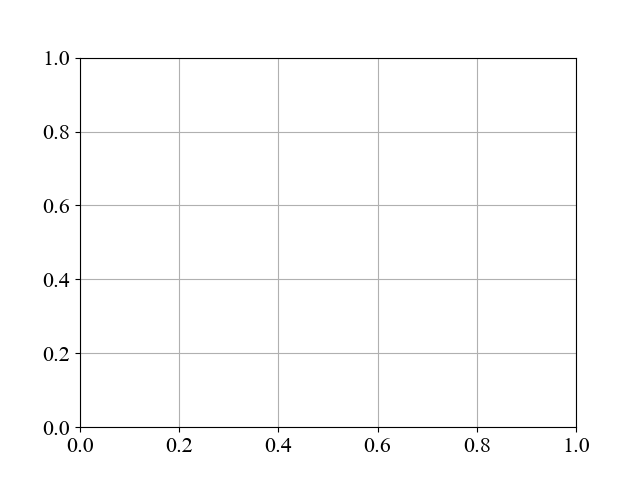

In [25]:
%matplotlib widget

#plt.scatter(dataset1['L:L7PADJ'],dataset1['L:D64BF'], label='D64BF Feb22')
#plt.scatter(dataset1['L:L7PADJ'],dataset1['L:D74BF'], label='D74BF Feb22')
#plt.scatter(dataset1['L:D64BF'],dataset1['B:HPQ4'], label='HPQ4')
#plt.scatter(dataset1['L:D64BF'],dataset1['B:HPQ5'], label='HPQ5')
#plt.scatter(dataset1['L:D64BF'],dataset1['B:VPQ5'], label='VPQ5')

#plt.scatter(dataset2['L:L7PADJ'],dataset2['L:D64BF'], label='D64BF Feb20')
#plt.scatter(dataset2['L:L7PADJ'],dataset2['L:D74BF'], label='D74BF Feb20')
#plt.scatter(dataset2['L:D64BF'],dataset2['B:HPQ4'], label='HPQ4')
#plt.scatter(dataset2['L:D64BF'],dataset2['B:HPQ5'], label='HPQ5')
#plt.scatter(dataset2['L:D64BF'],dataset2['B:VPQ5'], label='VPQ5')
plt.grid()
#print(dataset1['L:D64BF'].mean(),dataset2['L:D64BF'].mean())
#print(reference1['L:D74BF'], reference2['L:D74BF'])

### Split the data into train and test

We split the dataset into a training set and a test set.
The test set is used in the final evaluation of the model.

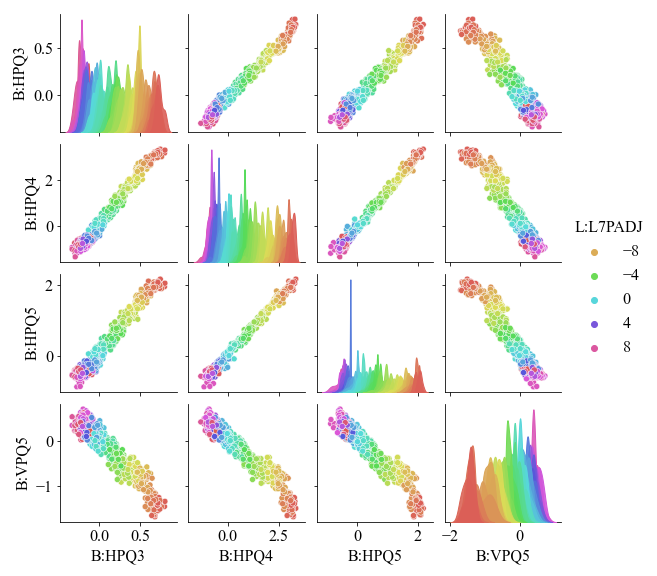

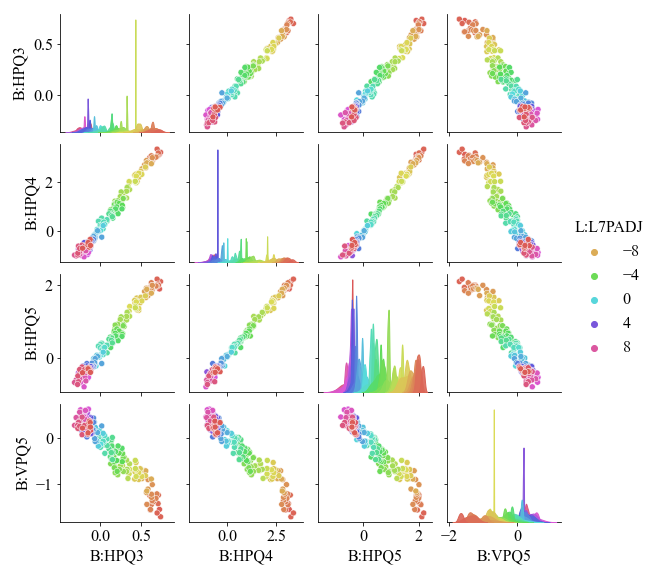

In [26]:
train_dataset1 = dataset1.sample(frac=0.8, random_state=25)
test_dataset1 = dataset1.drop(train_dataset1.index)

#inspect the data
sns.pairplot(train_dataset1, vars=['B:HPQ3','B:HPQ4','B:HPQ5','B:VPQ5'], hue='L:L7PADJ', palette='hls',diag_kind='kde',diag_kws={'alpha':0.9}, height=2.0)
sns.pairplot(test_dataset1, vars=['B:HPQ3','B:HPQ4','B:HPQ5','B:VPQ5'], hue='L:L7PADJ', palette='hls',diag_kind='kde',diag_kws={'alpha':0.9}, height=2.0)
#plt.savefig('l7padj_data_overview.pdf')

### Split features from labels

Separate the target values, the "labels", from the features. These labels are the values that we train the model to predict: RFQ, Buncher and Tank 5 phase.

In [27]:
train_features1, train_labels1 = fetch_features_labels(train_dataset1,['L:L7PADJ'])
test_features1, test_labels1 = fetch_features_labels(test_dataset1,['L:L7PADJ'])

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are. To improve training we normalize all inputs to the same range.

In [28]:
train_features1.describe().transpose()[['mean','std']].transpose()

,B:HPQ2,B:HPQ3,B:HPQ4,B:HPQ5,B:VPQ5
mean,-0.056629,0.073360,0.422515,0.313030,-0.128889
std,0.144059,0.286697,1.280158,0.821418,0.555645


### The Normalization layer
This calculates the mean and variance, and stores them in the layer. 
When the layer is called it returns the input data, with each feature independently normalized.

In [29]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features1))


Metal device set to: Apple M1


2023-06-30 16:25:32.918990: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-30 16:25:32.919761: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-06-30 16:25:33.006805: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-06-30 16:25:33.009081: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-30 16:25:33.055877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-06-30 16:25:33.067791: I tensorflow/core/grappler/

## Train the model

In [30]:
#%%time

#dnn_model11 = build_and_compile_model_nonorm(train_features.shape[1],initial_lr)
#dnn_model11 = build_and_compile_model(normalizer, initial_lr)
#history_flat = train_model(dnn_model11,train_features1,train_labels1,300)
#dnn_model11.summary()

In [31]:
%%time

dnn_model12 = build_and_compile_model(normalizer, initial_lr)
dnn_model12.summary()
history_time_decay = train_model(dnn_model12,train_features1,train_labels1,300,lr_time_based_decay)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense (Dense)                (None, 20)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 992
Trainable params: 981
Non-trainable params: 11
_________________________________________________________________


2023-06-30 16:25:39.730613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-06-30 16:25:41.764060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


CPU times: user 28.2 s, sys: 20.7 s, total: 48.9 s
Wall time: 32.8 s


In [37]:
%%time
dnn_model13 = build_and_compile_model(normalizer, initial_lr)
dnn_model13.summary()
history_step = train_model(dnn_model13,train_features1,train_labels1,800,lr_step_decay)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_20 (Dense)             (None, 20)                100       
_________________________________________________________________
dense_21 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_22 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 21        
Total params: 970
Trainable params: 961
Non-trainable params: 9
_________________________________________________________________


2023-05-02 09:36:36.695666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-05-02 09:36:36.960722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


CPU times: user 1min 25s, sys: 1min 1s, total: 2min 27s
Wall time: 1min 32s


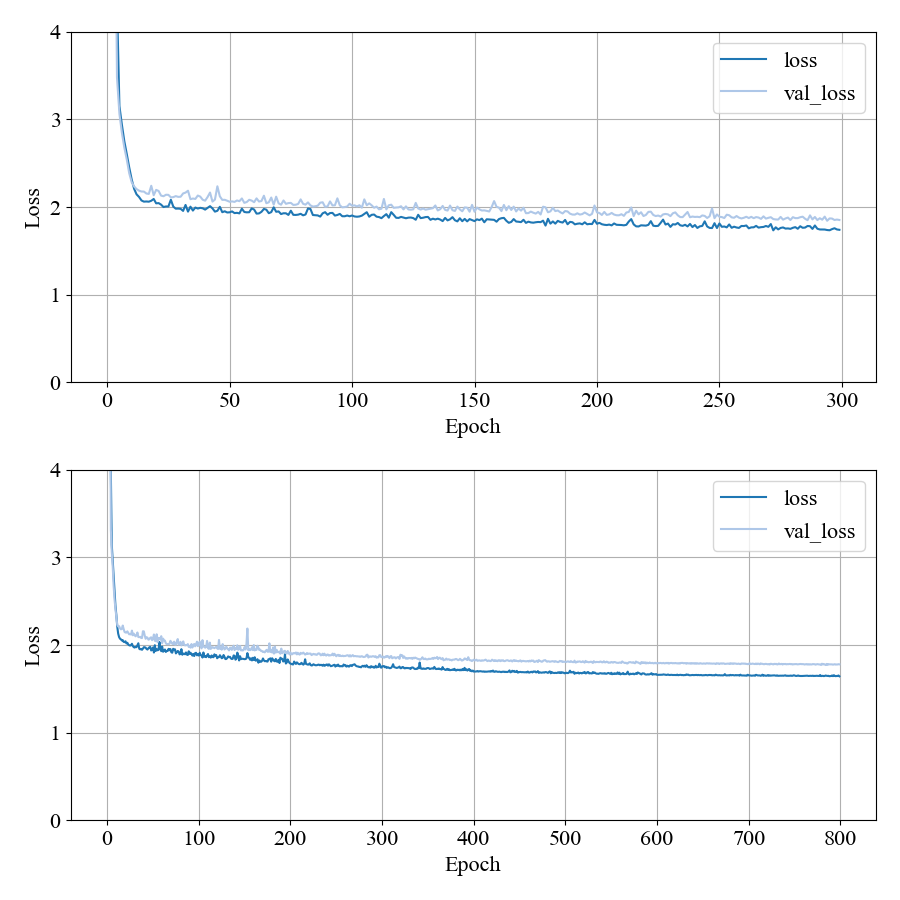

In [38]:
%matplotlib widget
plot_multi_loss([history_time_decay, history_step])
#plot_loss(history_step)

If you're happy with the model save it for later use:

In [39]:
dnn_model13.save('dnn_model13_l7padj_03052023')
# in the future, to load a trained model:
# loaded_model = tf.keras.models.load_model('dnn_model13_l7padj_22122022')
# my_features,my_labels = fetch_features_labels(vdf)
# my_predictions = loaded_model.predict(my_features)

INFO:tensorflow:Assets written to: dnn_model13_l7padj_03052023/assets


2023-05-02 09:38:48.451925: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Performance
Test the model on the test set:

In [40]:
test_results = {}

#test_results['dnn_model11'] = dnn_model11.evaluate(test_features1, test_labels1, verbose=1)
#test_results['dnn_model12'] = dnn_model12.evaluate(test_features1, test_labels1, verbose=1)
test_results['dnn_model12'] = dnn_model13.evaluate(test_features1, test_labels1, verbose=1)
test_predictions1 = dnn_model13.predict(test_features1)

7/7 [==============================] - 0s 8ms/step - loss: 2.0245


2023-05-02 09:38:55.362755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


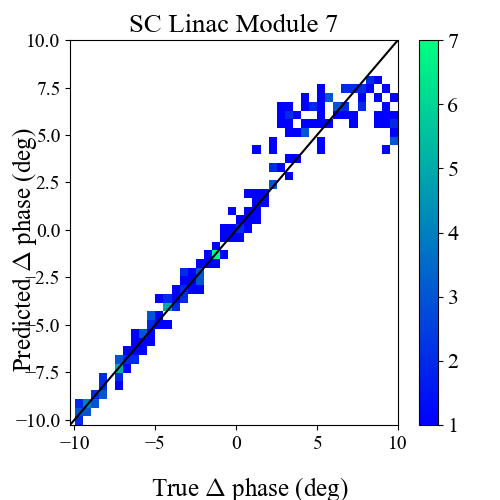

In [41]:
%matplotlib widget
plot_2dhist(test_predictions1,test_labels1)
#plt.savefig('predictionTrue_l7padj.pdf')

$\mu=-0.03$
$\sigma=1.42$


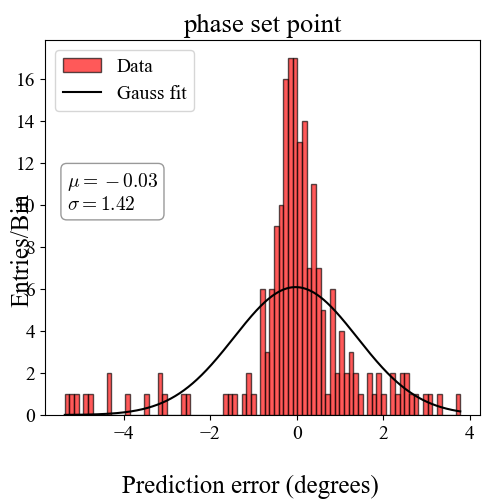

In [42]:
plot_1derror(test_predictions1,test_labels1)
#plt.savefig("predictionErr_l7padj.pdf")

# Validation on independent sample

In [47]:
val1 = r'devicescan_l7padj_loopON_52_10rep.csv'
vdf = fetch_data(val1,['L7PADJ','HPQ3','HPQ4','HPQ5','VPQ5'],'`L:L7PADJ`>72 &`L:L7PADJ`<92',['L:L7PADJ_R_'])
reference3 = fetch_reference(vdf,['L:L7PADJ'],[82.]) #87
vdf = vdf - reference3

val_features,val_labels = fetch_features_labels(vdf,['L:L7PADJ'])

vdf.describe()
val_predictions1 = dnn_model13.predict(val_features)
print(reference3)

      L:L7PADJ    B:HPQ3    B:HPQ4    B:HPQ5    B:VPQ5
270  72.105408  4.324601  4.694454  5.018632  5.683698
271  72.105408  4.341311  4.767979  5.023088  5.698180
272  72.105408  4.292295  4.726760  5.024202  5.800669
273  72.105408  4.320145  4.784689  5.037570  5.753881
274  72.105408  4.373618  4.928396  5.104411  5.426361
L:L7PADJ    82.099915
B:HPQ3       3.509477
B:HPQ4       0.966184
B:HPQ5       2.559224
B:VPQ5       7.017729
dtype: float64


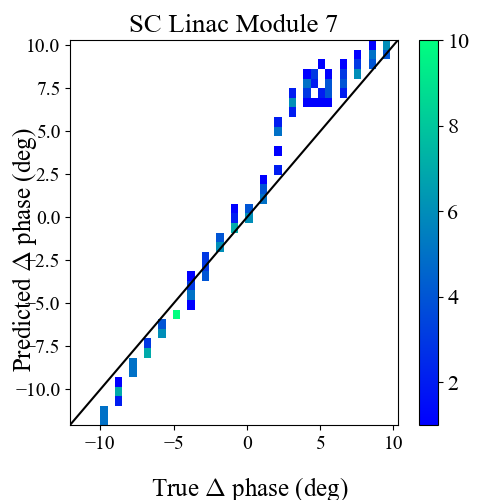

In [49]:
%matplotlib widget
plot_2dhist(val_predictions1,val_labels)

$\mu=0.64$
$\sigma=1.53$


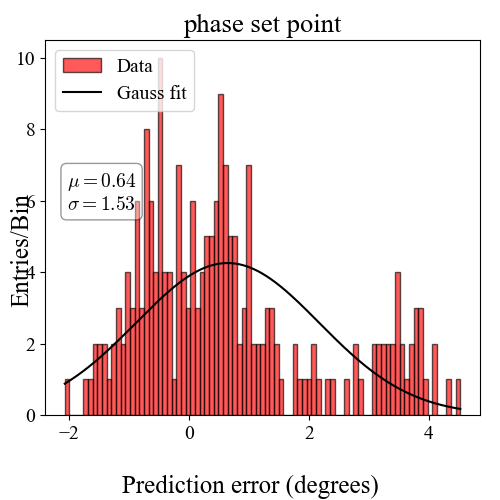

In [51]:
plot_1derror(val_predictions1,val_labels)

$\mu=-1.28$
$\sigma=2.75$


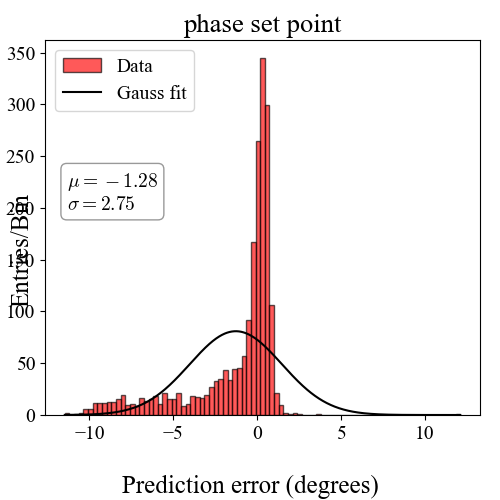

In [61]:
val_features2,val_labels2 = fetch_features_labels(dataset2,['L:L7PADJ'])

val_predictions2 = dnn_model13.predict(val_features2)

%matplotlib widget
#plot_2dhist(val_predictions2,val_labels2)
plot_1derror(val_predictions2,val_labels2)

# Tuning test

In [28]:
# First, we retrain the model with the appropriate reference: L7PADJ for that day
# 11 Jan 2023: L7PADJ 86.44
'''
reference2 = fetch_reference(dataset,'L:L7PADJ',86.44)
dataset2 = dataset - reference2

train_dataset2 = dataset2.sample(frac=0.9, random_state=10)
test_dataset2 = dataset2.drop(train_dataset2.index)

train_features2, train_labels2 = fetch_features_labels(train_dataset2,['L:L7PADJ'])
test_features2, test_labels2 = fetch_features_labels(test_dataset2,['L:L7PADJ'])

normalizer2 = preprocessing.Normalization(axis=-1)
normalizer2.adapt(np.array(train_features2))

dnn_model23 = build_and_compile_model(normalizer2, initial_lr)
history_step = train_model(dnn_model23,train_features2,train_labels2,800,lr_step_decay)

plot_loss(history_step)
'''

"\nreference2 = fetch_reference(dataset,'L:L7PADJ',86.44)\ndataset2 = dataset - reference2\n\ntrain_dataset2 = dataset2.sample(frac=0.9, random_state=10)\ntest_dataset2 = dataset2.drop(train_dataset2.index)\n\ntrain_features2, train_labels2 = fetch_features_labels(train_dataset2,['L:L7PADJ'])\ntest_features2, test_labels2 = fetch_features_labels(test_dataset2,['L:L7PADJ'])\n\nnormalizer2 = preprocessing.Normalization(axis=-1)\nnormalizer2.adapt(np.array(train_features2))\n\ndnn_model23 = build_and_compile_model(normalizer2, initial_lr)\nhistory_step = train_model(dnn_model23,train_features2,train_labels2,800,lr_step_decay)\n\nplot_loss(history_step)\n"

In [29]:
'''
%matplotlib inline
# 29 Dec 2022
# L7PADJ 86.3
hpq3b = 3.311
hpq4b = 0.819
hpq5b = 3.272
vpq5b = 9.944

# extractor V change
hpq3a = 3.4009
hpq4a = 1.0643
hpq5a = 3.3896
vpq5a = 9.9208


# Booster trims MH1, MV1 changed
#hpq3a = 3.3460
#hpq4a = 1.0027
#hpq5a = 3.2718
#vpq5a = 9.1727

# manually changed C7PHAS by 2 deg
#hpq3a = 3.392
#hpq4a = 1.189
#hpq5a = 3.513
#vpq5a = 9.785

# manually changed T5 
#hpq3a = 3.461
#hpq4a = 1.331
#hpq5a = 3.556
#vpq5a = 9.831


dhp3 = -hpq3a + hpq3b
dhp4 = -hpq4a + hpq4b
dhp5 = -hpq5a + hpq5b
dvp5 = -vpq5a + vpq5b


print(dhp3,dhp4,dhp5,dvp5)
'''

'\n%matplotlib inline\n# 29 Dec 2022\n# L7PADJ 86.3\nhpq3b = 3.311\nhpq4b = 0.819\nhpq5b = 3.272\nvpq5b = 9.944\n\n# extractor V change\nhpq3a = 3.4009\nhpq4a = 1.0643\nhpq5a = 3.3896\nvpq5a = 9.9208\n\n\n# Booster trims MH1, MV1 changed\n#hpq3a = 3.3460\n#hpq4a = 1.0027\n#hpq5a = 3.2718\n#vpq5a = 9.1727\n\n# manually changed C7PHAS by 2 deg\n#hpq3a = 3.392\n#hpq4a = 1.189\n#hpq5a = 3.513\n#vpq5a = 9.785\n\n# manually changed T5 \n#hpq3a = 3.461\n#hpq4a = 1.331\n#hpq5a = 3.556\n#vpq5a = 9.831\n\n\ndhp3 = -hpq3a + hpq3b\ndhp4 = -hpq4a + hpq4b\ndhp5 = -hpq5a + hpq5b\ndvp5 = -vpq5a + vpq5b\n\n\nprint(dhp3,dhp4,dhp5,dvp5)\n'

In [14]:
path = '/Users/rshara01/Desktop/LINAC_STUDY/BEAM STUDY 22FEB2023 C7PHAS/'
prefix = 'correlatedPulseData_L7padj_'
#prefix = 'L7PADJ_'
#prefix = 'Asfound_L7PADJ'
phases = ['80','81','82ref','83','84','86']

files = [r'%s%s%s.csv'%(path,prefix,ph) for ph in phases]

dfs = [pd.read_csv(f,skiprows=42) for f in files]
subs = [df.loc[:,list(df.filter(regex = 'L:C7PHAS|L7PADJ|HPQ3|HPQ4|HPQ5|VPQ5'))].dropna() for df in dfs]   
#subs = [subs[i] - subs[2] for i in range(len(files))] # subtract ref
subs[0].head()

,B:HPQ3,B:HPQ4,B:HPQ5,B:VPQ5,L:C7PHAS,L:L7PADJ
0,3.465697,2.055355,3.991511,4.712278,158.865509,80.047607
1,3.457898,1.928358,3.795445,4.591964,158.865509,80.047607
2,3.420022,2.063153,4.089544,4.697796,158.917969,80.047607
3,3.339813,1.747887,3.942494,4.691112,159.005402,80.047607
4,3.493547,2.070951,3.760910,4.669945,159.302673,80.047607


In [15]:
dphase = [sub['L:L7PADJ'].mean() for sub in subs]
var = ['B:HPQ3','B:HPQ4','B:HPQ5','B:VPQ5']
dpos = [[-sub[v].mean() for sub in subs] for v in var]

preds=list(next(zip(*dnn_model13.predict(pd.DataFrame(dict(zip(var,dpos)),index=range(len(dphase)))))))

print(preds)


NameError: name 'dnn_model13' is not defined

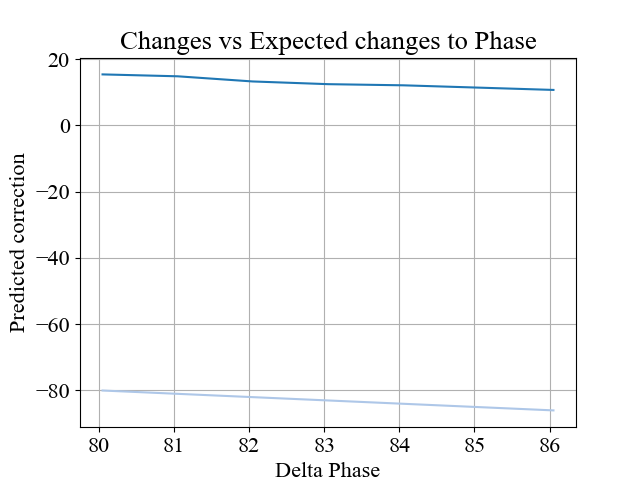

In [64]:
%matplotlib widget
plt.plot(dphase,preds)
plt.plot(dphase,np.multiply(dphase,-1))
plt.xlabel('Delta Phase')
plt.ylabel('Predicted correction')
plt.title('Changes vs Expected changes to Phase')
plt.grid()
#plt.show()

NameError: name 'subs' is not defined

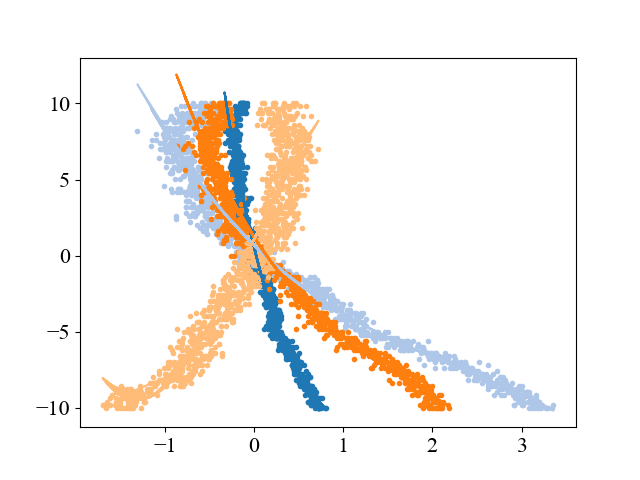

In [32]:
df = dataset1

df22= df.groupby(np.arange(len(df))//1).median()
df23= df.groupby(np.arange(len(df))//1).std()
df24=df23.rename(columns={'L:L7PADJ': 'L:L7PADJ_std', 'B:HPQ3': 'B:HPQ3_std', 'B:HPQ4': 'B:HPQ4_std','B:HPQ4': 'B:HPQ4_std','B:VPQ5': 'B:VPQ5_std'})
df25=pd.concat([df22,df24],axis=1)


%matplotlib widget
poly = [np.polyfit(df22[v],df22['L:L7PADJ'], deg=3) for v in var]
[plt.plot(df22[v],np.polyval(poly[j], df22[v])) for j,v in enumerate(var)]
[plt.scatter(df22[v],df22['L:L7PADJ'], marker='.', label=v) for v in var]

[plt.scatter(sub['B:HPQ5'].mean(),sub['L:L7PADJ'].mean(), marker='o', color='r') for jj,sub in enumerate(subs)]
[plt.scatter(sub['B:VPQ5'].mean(),sub['L:L7PADJ'].mean(), marker='o', color='magenta') for jj,sub in enumerate(subs)]
[plt.scatter(sub['B:HPQ4'].mean(),sub['L:L7PADJ'].mean(), marker='o', color='b') for jj,sub in enumerate(subs)]
[plt.scatter(sub['B:HPQ3'].mean(),sub['L:L7PADJ'].mean(), marker='o', color='k') for jj,sub in enumerate(subs)]

plt.scatter(subs[0]['B:HPQ5'].mean(),subs[0]['L:L7PADJ'].mean(), marker='o', color='r',label='Test data HPQ5')
plt.scatter(subs[0]['B:VPQ5'].mean(),subs[0]['L:L7PADJ'].mean(), marker='o', color='magenta',label='Test data VPQ5')
plt.scatter(subs[0]['B:HPQ4'].mean(),subs[0]['L:L7PADJ'].mean(), marker='o', color='b',label='Test data HPQ4')
plt.scatter(subs[0]['B:HPQ3'].mean(),subs[0]['L:L7PADJ'].mean(), marker='o', color='k',label='Test data HPQ3')
plt.legend()
plt.grid()
plt.xlabel('$\Delta x_{BPM}$ (mm)')
plt.ylabel('$\Delta \phi_{Mod7}$')

In [66]:
df5k = pd.read_csv('5100evt_nominal_c7phase_12042023.csv')
df5k.drop(list(df5k.filter(regex=r'\.1|Time|step|iter')),axis=1, inplace=True)
df5k = df5k.loc[df5k['B:HPQ5']>2]
df5k['L:L7PADJ'] = np.ones(df5k.shape[0])*84.83 #from datalogger
if len(subs)>6:
    subs.pop(-1)
subs.append(df5k.loc[:,list(df5k.filter(regex = 'L:C7PH|L7PADJ|HPQ3|HPQ4|HPQ5|VPQ5'))].dropna())

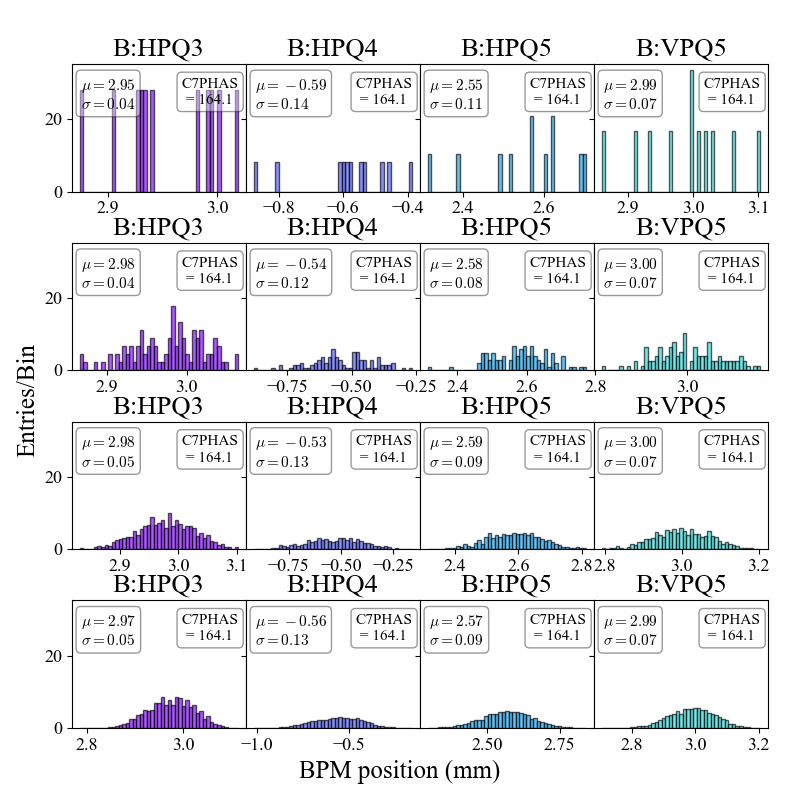

In [72]:
%matplotlib widget

colors = plt.cm.rainbow(np.linspace(0, 1, 10))

props = dict(boxstyle='round', facecolor='white', alpha=0.4)

nbins=45

test = []
nums = [10,100,1000,5000]
for n in nums:
    test.append(df5k.loc[:n,list(df5k.filter(regex = 'L:C7PH|L7PADJ|HPQ3|HPQ4|HPQ5|VPQ5'))].dropna())

fig, ax = plt.subplots(int(len(test)),int(len(var)), figsize=(2*len(var),2*int(len(test))),sharey=True)
fig.tight_layout()

for i,v in enumerate(var):    

    for j,s in enumerate(test):
        #if j <6:
        #    col = colors[i]
        #else:
        #
        col = colors[i]
        ax[j][i].hist(s[v], bins=nbins, edgecolor='k', alpha=0.65, label='C7PHAS=%.1f'%s['L:C7PHAS'].mean(),color=col, density=True)
        ax[j][i].set_title('%s'%v,y=1., loc='center')
        #ax.xaxis.label.set_size(13)
        #ax.yaxis.label.set_size(13)
       
        mean = np.mean(s[v])
        sigma = np.std(s[v])
        textstr = '\n'.join((
                    r'$\mu=%.2f$' % (mean,),
                    r'$\sigma=%.2f$' % (sigma,)))
        ax[j][i].text(0.05, 0.90, textstr, transform=ax[j][i].transAxes, color='k', fontsize=11,                                                                                
                           verticalalignment='top', bbox=props)
        ax[j][i].text(0.63, 0.90, 'C7PHAS\n = %.1f'%s['L:C7PHAS'].mean(), 
                      transform=ax[j][i].transAxes, color='k', fontsize=11,verticalalignment='top',bbox=props)
        #ax[j][i].legend(fontsize=10, loc='upper right')
        ax[j][i].tick_params(axis='both',labelsize=13)

fig.supylabel('Entries/Bin', fontsize=18)
fig.suptitle('BPM position (mm)', y=0.05, fontsize=18)
plt.subplots_adjust(wspace=0.0, hspace=0.4)
plt.subplots_adjust(bottom=0.09)
plt.subplots_adjust(top=0.92)
plt.subplots_adjust(left=0.09)
plt.subplots_adjust(right=0.96)  
